In [1]:
!pip install pandas==2.1.1
!pip install scorecardpy==0.1.9.7

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd, numpy as np
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint
import seaborn as sns

In [3]:
bureau_data=pd.read_csv('IS453 Group Assignment - Bureau Data.csv')
application_data=pd.read_csv('IS453 Group Assignment - Application Data.csv')

In [4]:

# choosing columns to keep 
application_data_cleaned = application_data[['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                            'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                            'NAME_INCOME_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
                                            'CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION', 'EXT_SOURCE_1', 'AMT_REQ_CREDIT_BUREAU_MON']]

# Now adding CREDIT_CURRENCY to the bureau columns we keep
bureau_data_cleaned = bureau_data[['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE',
                                  'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
                                  'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']]

# Filter application data for non-car owners
app_filtered = application_data_cleaned[application_data_cleaned['FLAG_OWN_CAR'] == 'N'].copy()
app_filtered.drop(['FLAG_OWN_CAR'], axis = 1, inplace = True)
# Filter bureau data for currency 1
bureau_filtered = bureau_data_cleaned[bureau_data_cleaned['CREDIT_CURRENCY'] == 'currency 1'].copy()
bureau_filtered.drop(['CREDIT_CURRENCY'], axis = 1, inplace = True)
bureau_filtered = bureau_filtered[bureau_filtered['CREDIT_TYPE'] != 'Car loan']

# Aggregating Bureau Data for each application (SK_ID_CURR) - using filtered bureau data
bureau_aggregated = bureau_filtered.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',  # Number of past loans
    'CREDIT_ACTIVE': lambda x: x.value_counts().idxmax(),  # Most frequent credit status
    'CREDIT_DAY_OVERDUE': 'mean',  # Average overdue days
    'AMT_CREDIT_MAX_OVERDUE': 'max',  # Max overdue amount
    'CNT_CREDIT_PROLONG': 'sum',  # Total prolongations
    'AMT_CREDIT_SUM': 'sum',  # Total outstanding credit
    'AMT_CREDIT_SUM_DEBT': 'mean',  # Average current debt
    'AMT_CREDIT_SUM_OVERDUE': 'max',  # Max overdue amount
    'CREDIT_TYPE': lambda x: x.value_counts().idxmax(),  # Most frequent credit type
    'DAYS_CREDIT_UPDATE': 'min',  # Most recent credit update
    'AMT_ANNUITY': 'mean',  # Average annuity payment
}).reset_index()

# Feature engineering
# Rename SK_ID_BUREAU count column
bureau_aggregated.rename(columns={"SK_ID_BUREAU": "CREDIT_COUNT"}, inplace=True)



In [5]:
# Create a new feature for overdue credit count (using the filtered bureau data)
bureau_aggregated['OVERDUE_CREDIT_COUNT'] = bureau_filtered[bureau_filtered['CREDIT_DAY_OVERDUE'] > 0].groupby('SK_ID_CURR')['SK_ID_BUREAU'].transform('count')

# Merge the filtered application data with filtered bureau data
merged_data = app_filtered.merge(bureau_aggregated, on='SK_ID_CURR', how='left')



# number of rows
# rows = merged_data.shape[0]
# print(f"Number of rows after selection: {rows}")

# calculate percentage of bad loans after filtering
# total_loans = len(app_filtered)
# bad_loans = app_filtered[app_filtered['TARGET'] == 1].shape[0]
# print(f"Number of Bad Loans after selection:{bad_loans}")
# bad_loans_percentage = (bad_loans / total_loans) * 100
# print(f"Percentage of Bad Loans after filtering: {bad_loans_percentage:.2f}%")

# # calculate percentage of bad loans in orig dataset
# total_loans = len(application_data_cleaned)
# bad_loans = application_data_cleaned[application_data_cleaned['TARGET'] == 1].shape[0]
# bad_loans_percentage = (bad_loans / total_loans) * 100
# print(f"Percentage of Bad Loans in orig dataset: {bad_loans_percentage:.2f}%")

## working data based on week 11 content

In [14]:
working_data = merged_data.copy()
working_data = working_data.drop(columns=['FLAG_MOBIL', 'SK_ID_CURR'])
train, test = sc.split_df(hmeq_data_forsc, y = 'TARGET', ratio = .7).values()
train = train.copy()
test = test.copy()
bins = sc.woebin(train, y = 'TARGET')
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe, test_woe = drop_low_iv_high_corr(train_woe, test_woe)
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/19, pdo = 20, basepoints_eq0 = True)
train_score = sc.scorecard_ply(train.copy(), card)
test_score = sc.scorecard_ply(test.copy(), card)

[INFO] creating woe binning ...
Binning on 142046 rows and 26 columns in 00:00:19
[INFO] converting into woe values ...
[INFO] converting into woe values ...
             Feature_1            Feature_2  Correlation
7  AMT_GOODS_PRICE_woe       AMT_CREDIT_woe     0.875293
8       AMT_CREDIT_woe  AMT_GOODS_PRICE_woe     0.875293


In [ ]:
bins = sc.woebin(train, y = 'TARGET')

# for variables, bindetails in bins.items():
#     print(variables, " : ")
#     display(bindetails)
#     print("--"*50)

In [13]:
def drop_low_iv_high_corr(train_woe, test_woe):
    # drop low IVs (below 0.02)
    selected_columns = (
        'TARGET', 'AMT_CREDIT_SUM_DEBT_woe', 'CREDIT_ACTIVE_woe', 'NAME_INCOME_TYPE_woe',
        'EXT_SOURCE_1_woe', 'DAYS_CREDIT_UPDATE_woe', 'AMT_GOODS_PRICE_woe', 'AMT_CREDIT_woe', 'DAYS_EMPLOYED_woe',
        'AMT_ANNUITY_x_woe', 'AMT_CREDIT_MAX_OVERDUE_woe'
    )
    train_woe = train_woe.loc[:, selected_columns]
    test_woe = test_woe.loc[:, selected_columns]

    correlation_matrix = train_woe.corr()
    correlation_threshold = 0.7

    # Find highly correlated pairs (excluding self-correlations)
    high_correlation_pairs = correlation_matrix.where(np.abs(correlation_matrix) > correlation_threshold).stack().reset_index()
    high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

    # Remove duplicate pairs (since correlation is symmetric)
    high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2']]

    # Display highly correlated pairs
    print(high_correlation_pairs)

    # keep amt goods price because higher IV, remove amt_credit
    selected_columns = (
        'TARGET', 'AMT_CREDIT_SUM_DEBT_woe', 'CREDIT_ACTIVE_woe', 'NAME_INCOME_TYPE_woe',
        'EXT_SOURCE_1_woe', 'DAYS_CREDIT_UPDATE_woe', 'AMT_GOODS_PRICE_woe', 'DAYS_EMPLOYED_woe',
        'AMT_ANNUITY_x_woe', 'AMT_CREDIT_MAX_OVERDUE_woe'
    )

    train_woe = train_woe.loc[:, selected_columns]
    test_woe = test_woe.loc[:, selected_columns]
    return train_woe, test_woe

In [34]:
# 5:1 of default
# cutoff=560

# 5:4 of default
cutoff = 520

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))

print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[65482 64490]
 [ 3184  8890]]
PCC measures:
              precision    recall  f1-score   support

           0       0.95      0.50      0.66    129972
           1       0.12      0.74      0.21     12074

    accuracy                           0.52    142046
   macro avg       0.54      0.62      0.43    142046
weighted avg       0.88      0.52      0.62    142046

*** Test Data Performance ***
Confusion matrix:
[[28169 27534]
 [ 1376  3799]]
PCC measures:
              precision    recall  f1-score   support

           0       0.95      0.51      0.66     55703
           1       0.12      0.73      0.21      5175

    accuracy                           0.53     60878
   macro avg       0.54      0.62      0.43     60878
weighted avg       0.88      0.53      0.62     60878



Cutoff score of 520: 65,185 applications approved (45.9%)


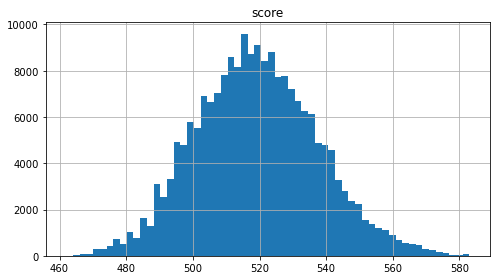

In [36]:
# combine scores for train and test data to assess distribution for entire population
combined_score = pd.concat([train_score, test_score], ignore_index=True)

# plot distribution of scores on copmbined data
combined_score.hist(figsize = (7, 4), bins = 60)
plt.tight_layout()

# sample code
cutoff = 520

approval_count = train_score[train_score["score"]>cutoff].count()['score']
approval_rate = approval_count/train_score.shape[0]
print(f'Cutoff score of {cutoff:.0f}: {approval_count:,.0f} applications approved ({approval_rate:.1%})')

In [37]:
# sample code

# calculate expected number of defaults
odds_at_cutoff = 1.25

default_prob = 1/(1+odds_at_cutoff)
defaults = default_prob*approval_count
print(f'Cutoff score of {cutoff:.0f}: {defaults:.0f} defaults expected')

Cutoff score of 520: 28971 defaults expected


In [38]:
pprint.pprint(card)

{'AMT_ANNUITY_x':          variable                bin  points
61  AMT_ANNUITY_x            missing    52.0
62  AMT_ANNUITY_x     [-inf,16000.0)    60.0
63  AMT_ANNUITY_x  [16000.0,24000.0)    56.0
64  AMT_ANNUITY_x  [24000.0,42000.0)    55.0
65  AMT_ANNUITY_x      [42000.0,inf)    62.0,
 'AMT_CREDIT_MAX_OVERDUE':                   variable              bin  points
82  AMT_CREDIT_MAX_OVERDUE          missing    56.0
83  AMT_CREDIT_MAX_OVERDUE    [-inf,1500.0)    62.0
84  AMT_CREDIT_MAX_OVERDUE  [1500.0,5500.0)    50.0
85  AMT_CREDIT_MAX_OVERDUE     [5500.0,inf)    51.0,
 'AMT_CREDIT_SUM_DEBT':               variable                 bin  points
3  AMT_CREDIT_SUM_DEBT             missing    54.0
4  AMT_CREDIT_SUM_DEBT      [-inf,20000.0)    64.0
5  AMT_CREDIT_SUM_DEBT   [20000.0,80000.0)    57.0
6  AMT_CREDIT_SUM_DEBT  [80000.0,300000.0)    52.0
7  AMT_CREDIT_SUM_DEBT      [300000.0,inf)    56.0,
 'AMT_GOODS_PRICE':            variable                   bin  points
86  AMT_GOODS_PRICE   